In [278]:
import pandas as pd
import geopandas as gpd
import os
import sys
import matplotlib.pyplot as plt
from shapely.geometry import box

# import helpers from casey lab shared functions
code_path = "/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code"
sys.path.append(str(code_path))
from num_people_affected_helpers import *

In [280]:
# read fire data 
fires = gpd.read_file('/Volumes/squirrel-utopia 3/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data/01_calfire_boundaries/data_2025_01_21.geojson')

In [281]:
# filter to relevant fires after the date we care about 
fires["poly_DateCurrent"] = fires["poly_DateCurrent"].dt.tz_convert('US/Pacific')
fires = fires[fires['poly_DateCurrent'] > '2025-01-06']
fires["poly_DateCurrent"] = fires["poly_DateCurrent"].dt.date

# fill in names for all fires - this is bad for the kenneth fire, one 
# kenneth also includes palisades 
fires["incident_name"] = fires["incident_name"].str.lower()
fires['incident_name'].fillna(fires['mission'].str.split('-').str[2].str.lower(), inplace=True)

# filter to only the cols we need
# incident_name, poly_DateCurrent, geometry
fires = fires[["incident_name", "poly_DateCurrent", "geometry"]]
fires = fires.to_crs(epsg=3857)

/var/folders/8y/9yw138b95kjd5wjs3my5vy900000gn/T/ipykernel_27912/1818679461.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fires['incident_name'].fillna(fires['mission'].str.split('-').str[2].str.lower(), inplace=True)


Bounds of the geometries after clipping:
[-118.702496     34.160377   -118.668713     34.18776756]


/opt/homebrew/Caskroom/miniforge/base/envs/wf/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


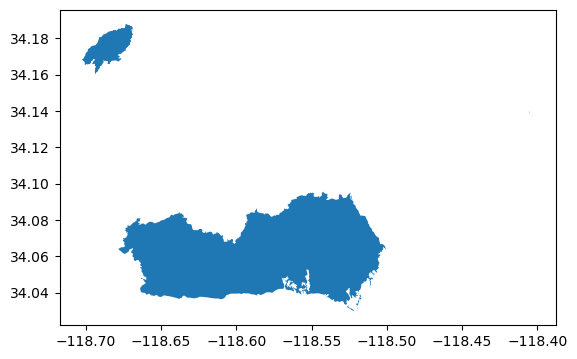

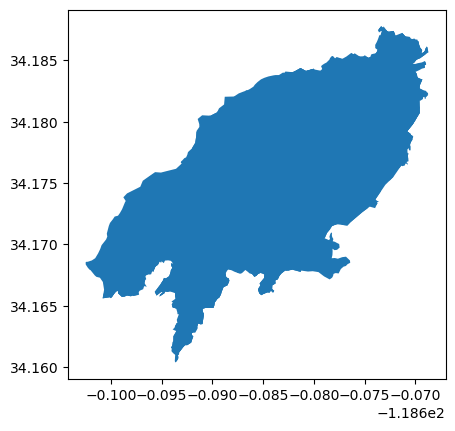

In [282]:
# fix kenneth fire 
fires = fires.to_crs(epsg=4326)
incident_name_to_clip = 'kenneth'  # Replace with the actual incident name

# Filter the GeoDataFrame to get the geometries associated with the specific incident name
incident_fires = fires[fires['incident_name'] == incident_name_to_clip]

incident_fires.plot()

# Define the clipping box (xmin, ymin, xmax, ymax)
clipping_box = box(-118.80, 34.16, -118.40, 34.19)  # Replace with the actual coordinates

# Perform the clipping operation
incident_fires['geometry'] = incident_fires['geometry'].intersection(clipping_box)

# Remove any empty geometries resulting from the clipping
incident_fires = incident_fires[~incident_fires.is_empty]

# Print the bounds of the geometries after clipping
print("Bounds of the geometries after clipping:")
print(incident_fires['geometry'].total_bounds)

incident_fires.plot()
fires.update(incident_fires)


/opt/homebrew/Caskroom/miniforge/base/envs/wf/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


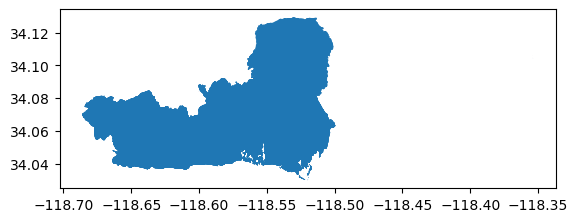

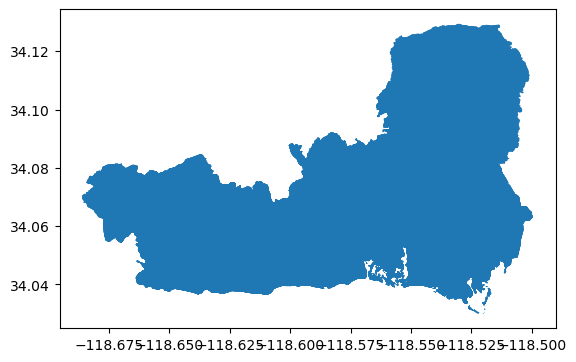

In [283]:
# fix sunset
incident_name_to_clip = 'palisades'  # Replace with the actual incident name

# Filter the GeoDataFrame to get the geometries associated with the specific incident name
incident_fires = fires[fires['incident_name'] == incident_name_to_clip]
incident_fires.plot()

# # Define the clipping box (xmin, ymin, xmax, ymax)
clipping_box = box(-118.80, 34.00, -118.47, 34.19)  # Replace with the actual coordinates

# # Perform the clipping operation
incident_fires['geometry'] = incident_fires['geometry'].intersection(clipping_box)

# # Remove any empty geometries resulting from the clipping
incident_fires = incident_fires[~incident_fires.is_empty]

# # Print the bounds of the geometries after clipping
# print("Bounds of the geometries after clipping:")
# print(incident_fires['geometry'].total_bounds)

incident_fires.plot()
fires.update(incident_fires)

In [284]:
# remove sunswept, pala, and lilac fires

fires = fires[~fires['incident_name'].str.contains('sunswept')]
fires = fires[~fires['incident_name'].str.contains('pala')]
fires = fires[~fires['incident_name'].str.contains('lilac')]
fires = fires.reset_index(drop=True)

print(fires)

   incident_name poly_DateCurrent  \
0      palisades       2025-01-07   
1      palisades       2025-01-07   
2      palisades       2025-01-07   
3      palisades       2025-01-07   
4      palisades       2025-01-08   
5      palisades       2025-01-08   
6          lidia       2025-01-08   
7         sunset       2025-01-08   
8          eaton       2025-01-08   
9          hurst       2025-01-08   
10        sunset       2025-01-08   
11     palisades       2025-01-08   
12       kenneth       2025-01-09   
13     palisades       2025-01-09   
14         hurst       2025-01-09   
15         hurst       2025-01-09   
16         eaton       2025-01-09   
17       kenneth       2025-01-09   
18       kenneth       2025-01-09   
19       kenneth       2025-01-09   
20       kenneth       2025-01-09   
21     palisades       2025-01-10   
22         eaton       2025-01-10   
23        archer       2025-01-10   
24     palisades       2025-01-08   
25     palisades       2025-01-10   
2

In [285]:
# select just incident name and geometry
fires = fires[["incident_name", "geometry"]]
fires = fires.reset_index(drop=True)

fires['incident_name'] = fires['incident_name'].str.strip()
fires['geometry'] = fires['geometry'].buffer(0)

grouped_fires = fires.dissolve(by='incident_name', as_index=False)
# drop duplicate rows



grouped_fires = grouped_fires.reset_index(drop=True)


In [286]:
print(grouped_fires)

  incident_name                                           geometry
0        archer  MULTIPOLYGON (((-118.51183 34.30772, -118.5119...
1          auto  MULTIPOLYGON (((-119.21283 34.23611, -119.2128...
2         eaton  MULTIPOLYGON (((-118.15682 34.18148, -118.1565...
3         hurst  POLYGON ((-118.46957 34.33032, -118.46961 34.3...
4       kenneth  POLYGON ((-118.69312 34.17665, -118.69309 34.1...
5         lidia  POLYGON ((-118.25563 34.43419, -118.25547 34.4...
6     palisades  MULTIPOLYGON (((-118.56147 34.04313, -118.5614...
7        sunset  MULTIPOLYGON (((-118.35379 34.10447, -118.3537...


<Axes: >

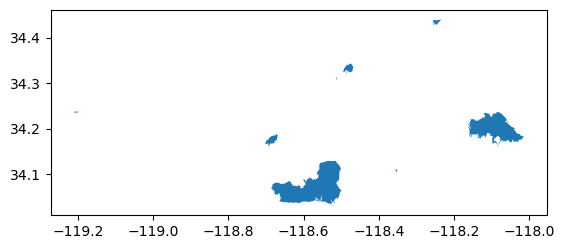

In [287]:
grouped_fires.plot()

<Axes: >

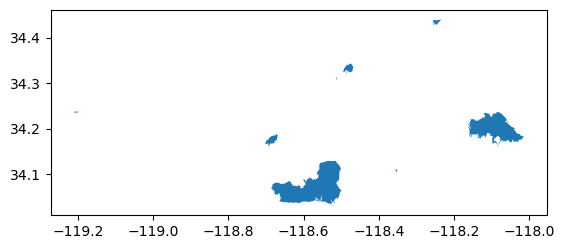

In [288]:
from shapely.geometry import box

grouped_fires = grouped_fires.to_crs(epsg=4326)
grouped_fires.plot()


In [289]:

# Define the clipping box (xmin, ymin, xmax, ymax)
clipping_box = box(-119, 33, -117, 35)

# Perform the clipping operation
fires_clipped = grouped_fires.copy()
fires_clipped['geometry'] = fires_clipped['geometry'].intersection(clipping_box)

# Remove any empty geometries resulting from the clipping
fires_clipped = fires_clipped[~fires_clipped.is_empty]
print(fires_clipped)

  incident_name                                           geometry
0        archer  MULTIPOLYGON (((-118.51195 34.30783, -118.5120...
2         eaton  MULTIPOLYGON (((-118.15659 34.18148, -118.1565...
3         hurst  POLYGON ((-118.46961 34.33016, -118.46961 34.3...
4       kenneth  POLYGON ((-118.69309 34.17675, -118.69295 34.1...
5         lidia  POLYGON ((-118.25547 34.4342, -118.25508 34.43...
6     palisades  MULTIPOLYGON (((-118.56147 34.04313, -118.5615...
7        sunset  MULTIPOLYGON (((-118.35374 34.10441, -118.3537...


<Axes: >

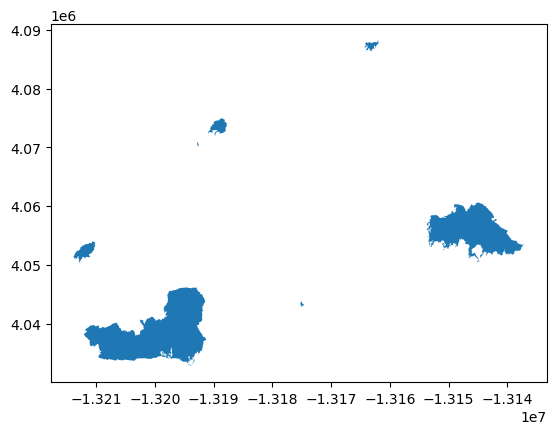

In [290]:
# buffer grouped fires by 500m
fires_clipped = fires_clipped.to_crs(epsg=3857)

#fires_clipped['geometry'] = fires_clipped['geometry'].buffer(500)
fires_clipped.plot()

In [291]:
print(fires_clipped.head())
# reset index

fires_clipped = fires_clipped.reset_index(drop=True)


  incident_name                                           geometry
0        archer  MULTIPOLYGON (((-13192690.28 4070210.78, -1319...
2         eaton  MULTIPOLYGON (((-13153131.126 4053196.882, -13...
3         hurst  POLYGON ((-13187976.738 4073220.968, -13187976...
4       kenneth  POLYGON ((-13212854.562 4052559.324, -13212839...
5         lidia  POLYGON ((-13164139.116 4087254.104, -13164095...


In [292]:
# save this dataframe
fires_clipped.to_parquet('/Volumes/squirrel-utopia 3/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data/02_processed/cleaned_LA_wfs_to_2025_01_21.parquet')


<Axes: >

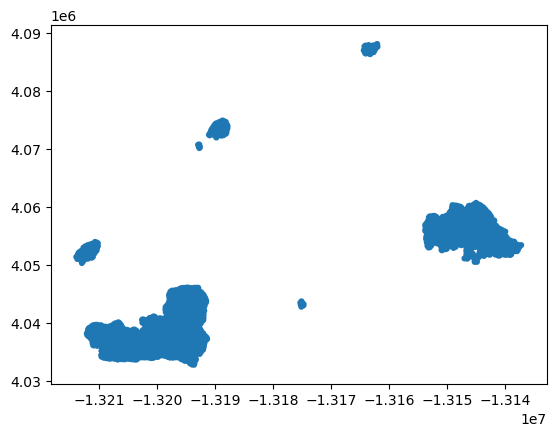

In [293]:
# buffer fires clipped by 500 m
fires_clipped['geometry'] = fires_clipped['geometry'].buffer(500)
fires_clipped.plot()

In [294]:
la_wf_path = '/Volumes/squirrel-utopia 3/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data/02_processed/cleaned_LA_wfs_to_2025_01_21.parquet'
ghs_pop_path = "/Volumes/squirrel-utopia 3/GHSL/100 m/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif"

In [295]:
# run find num people affected
num_poeple_aff_500_m = find_num_people_affected(path_to_hazards = la_wf_path,
                                                raster_path=ghs_pop_path,
                                                buffer_dist_large = 500,
                                                buffer_dist_small = 500,
                                                area_thresh_for_large_buffer = 0)

num_poeple_aff_5_km = find_num_people_affected(path_to_hazards = la_wf_path,
                                                raster_path=ghs_pop_path,
                                                buffer_dist_large = 5000,
                                                buffer_dist_small = 5000,
                                                area_thresh_for_large_buffer = 0)

num_poeple_aff_10_km = find_num_people_affected(path_to_hazards = la_wf_path,
                                                raster_path=ghs_pop_path,
                                                buffer_dist_large = 10000,
                                                buffer_dist_small = 10000,
                                                area_thresh_for_large_buffer = 0)


/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code/num_people_affected_helpers.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_shp["centroid_lon"] = ch_shp.centroid.x
/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code/num_people_affected_helpers.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_shp["centroid_lat"] = ch_shp.centroid.y


Running the function
Reading data and finding best UTM projection for hazard geometries (1/6)


Masking raster (6/6): 100%|██████████| 7/7 [00:00<00:00, 93.87it/s]
/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code/num_people_affected_helpers.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_shp["centroid_lon"] = ch_shp.centroid.x
/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code/num_people_affected_helpers.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_shp["centroid_lat"] = ch_shp.centroid.y


Running the function
Reading data and finding best UTM projection for hazard geometries (1/6)


Masking raster (6/6): 100%|██████████| 5/5 [00:00<00:00, 82.40it/s]
/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code/num_people_affected_helpers.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_shp["centroid_lon"] = ch_shp.centroid.x
/Users/heathermcbrien/Documents/Documents/GitHub.nosync/casey_lab_shared_functions/wf_disaster_exp_by_geo/code/num_people_affected_helpers.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_shp["centroid_lat"] = ch_shp.centroid.y


Running the function
Reading data and finding best UTM projection for hazard geometries (1/6)


Masking raster (6/6): 100%|██████████| 2/2 [00:00<00:00, 48.98it/s]


In [296]:
print(num_poeple_aff_500_m)
print(num_poeple_aff_5_km)
print(num_poeple_aff_10_km)

  ID_climate_hazard  num_people_affected
0             eaton         61588.137252
1             lidia            61.344552
2            sunset          6509.214536
3             hurst          3673.258478
4            archer          1471.049747
5           kenneth          4759.491245
6         palisades         34077.939782
     ID_climate_hazard  num_people_affected
0                eaton        313040.832728
1                lidia          1655.829627
2               sunset        314221.666194
3       archer___hurst        145222.020013
4  palisades___kenneth        374712.194067
                                   ID_climate_hazard  num_people_affected
0                                              lidia         9.759214e+03
1  palisades___sunset___kenneth___eaton___archer_...         3.913478e+06


In [297]:
# round num_people affected to whole numbers

num_poeple_aff_500_m = num_poeple_aff_500_m.round(0)
num_poeple_aff_5_km = num_poeple_aff_5_km.round(0)
num_poeple_aff_10_km = num_poeple_aff_10_km.round(0)

# make it all one dataframe
num_poeple_aff_500_m['buffer_dist'] = '500 m'
num_poeple_aff_5_km['buffer_dist'] = "5 km"
num_poeple_aff_10_km['buffer_dist'] = "10 km"

# join all
num_people_affected = pd.concat([num_poeple_aff_500_m, num_poeple_aff_5_km, num_poeple_aff_10_km])


In [298]:
print(num_people_affected)
# save to csv
num_people_affected.to_csv('/Volumes/squirrel-utopia 3/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data/02_processed/num_people_residing_near_each_fire.csv')

                                   ID_climate_hazard  num_people_affected  \
0                                              eaton              61588.0   
1                                              lidia                 61.0   
2                                             sunset               6509.0   
3                                              hurst               3673.0   
4                                             archer               1471.0   
5                                            kenneth               4759.0   
6                                          palisades              34078.0   
0                                              eaton             313041.0   
1                                              lidia               1656.0   
2                                             sunset             314222.0   
3                                     archer___hurst             145222.0   
4                                palisades___kenneth             374712.0   